In [84]:
%pip install --q fastkaggle

Note: you may need to restart the kernel to use updated packages.


In [85]:
from fastai.vision.all import *
from fastai.imports import *
from fastkaggle import *
import torch.nn as nn

In [86]:
if iskaggle:
    path = Path("/kaggle/input/deforestationpreprocessed") / "archive"
else:
    path = Path.cwd() / "archive"

In [87]:
md_df = pd.read_csv(path / "metadata.csv")

In [88]:
md_df.head()

,image_id,split,sat_image_path,mask_path
0,100694,train,train/100694_sat.jpg,train/100694_mask.png
1,102122,train,train/102122_sat.jpg,train/102122_mask.png
2,10233,train,train/10233_sat.jpg,train/10233_mask.png
3,103665,train,train/103665_sat.jpg,train/103665_mask.png
4,103730,train,train/103730_sat.jpg,train/103730_mask.png


In [89]:
class_df = pd.read_csv(path / "class_dict.csv")
class_df.head()

,name,r,g,b
0,urban_land,0,255,255
1,agriculture_land,255,255,0
2,rangeland,255,0,255
3,forest_land,0,255,0
4,water,0,0,255


In [90]:
classes = class_df["name"].to_numpy(); classes

array(['urban_land', 'agriculture_land', 'rangeland', 'forest_land',
       'water', 'barren_land', 'unknown'], dtype=object)

In [91]:
def label_func(path):
    fname = path.name
    img_id = str(fname.split("_sat")[0])
    return path.parent / (img_id + "_mask_pre.png")

In [92]:
fnames = get_image_files(path / "train")
fnames = [fn for fn in fnames if fn.name.endswith("_sat.jpg")]
fnames[:5]

[Path('/kaggle/input/deforestationpreprocessed/archive/train/651774_sat.jpg'),
 Path('/kaggle/input/deforestationpreprocessed/archive/train/170535_sat.jpg'),
 Path('/kaggle/input/deforestationpreprocessed/archive/train/995492_sat.jpg'),
 Path('/kaggle/input/deforestationpreprocessed/archive/train/576417_sat.jpg'),
 Path('/kaggle/input/deforestationpreprocessed/archive/train/923223_sat.jpg')]

In [94]:
dls = SegmentationDataLoaders.from_label_func(
    path,
    bs=8,
    fnames=fnames,
    label_func=label_func,
    codes=classes,
    item_tfms=Resize(128),
    loss_func=FocalLossFlat(gamma=2),
)

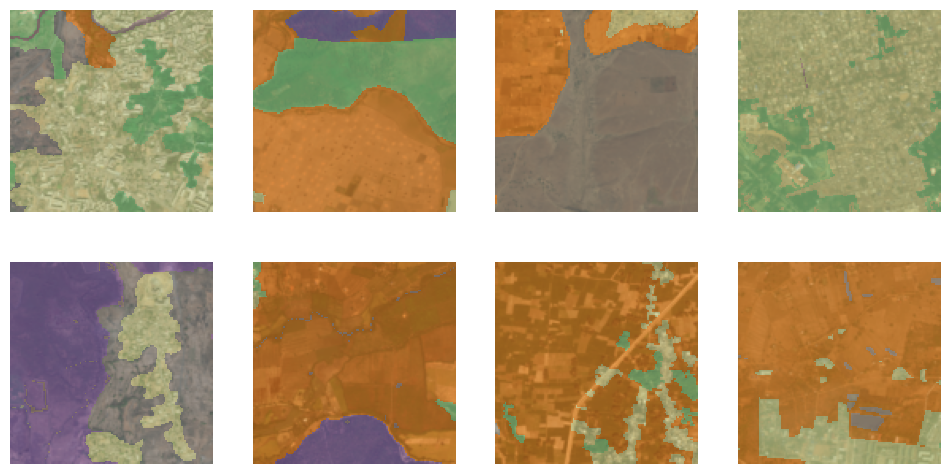

In [98]:
dls.show_batch()

In [99]:
import timm
from functools import partial
model = partial(timm.create_model, "timm/convnext_large.fb_in22k")

In [102]:
learner = unet_learner(dls, model, cbs=GradientAccumulation(4), metrics=[DiceMulti])

In [103]:
learner.fine_tune(10)

epoch,train_loss,valid_loss,dice_multi,time
0,1.405890,1.380009,0.119955,01:41


epoch,train_loss,valid_loss,dice_multi,time
0,0.913468,0.835173,0.550726,01:49
1,0.848675,0.916123,0.507381,01:48
2,0.805109,0.750964,0.601751,01:48
3,0.745881,0.676777,0.599609,01:49
4,0.660919,0.700922,0.634028,01:48
5,0.599074,0.646799,0.668308,01:48
6,0.548015,0.589333,0.688340,01:48
7,0.476521,0.574199,0.704269,01:48
8,0.433217,0.576709,0.712167,01:49
9,0.398783,0.570978,0.706048,01:48


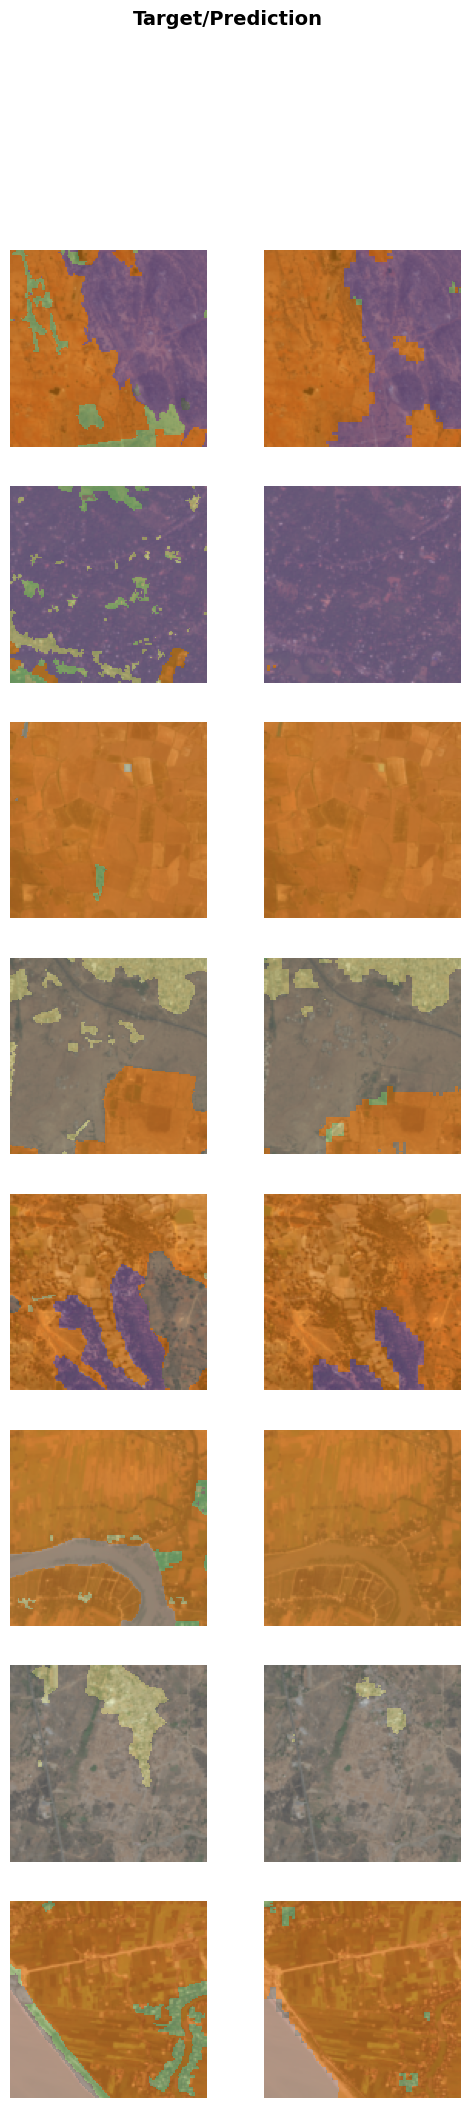

In [104]:
learner.show_results()

In [105]:
if iskaggle:
    out_path = Path("/kaggle/working/")
else: out_path = Path.cwd()

learner.export(out_path / "convnext_base_256px_8bs_68ds.pkl")

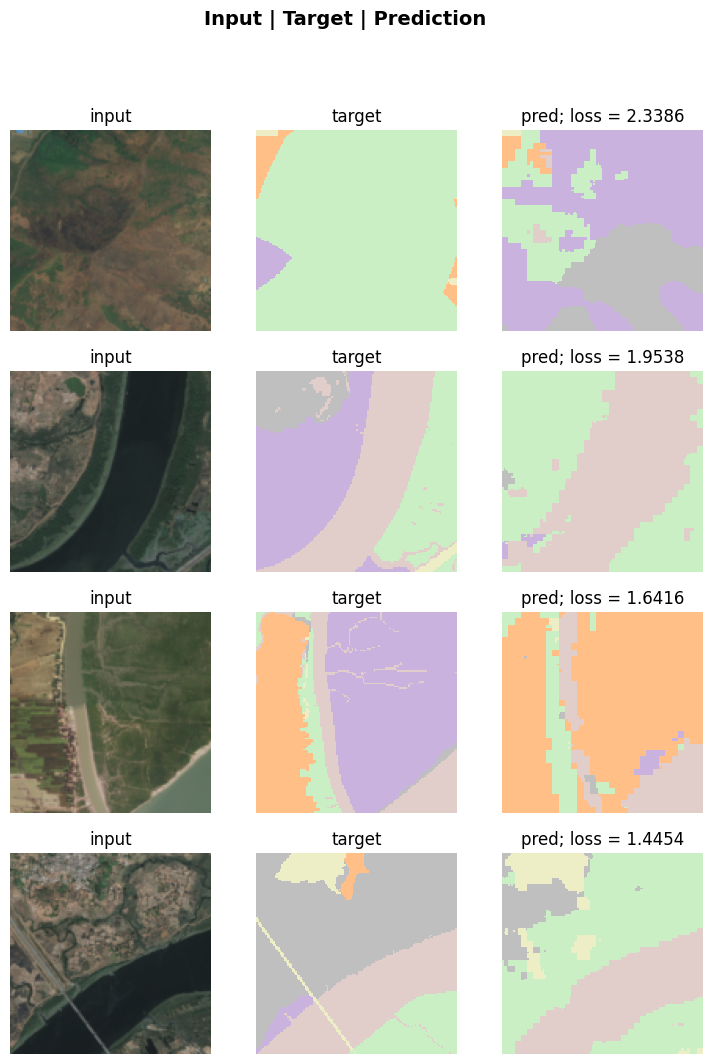

In [106]:
interp = Interpretation.from_learner(learner)
interp.plot_top_losses(4)